In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google-genai langchain_community langchain_core tavily-python wikipedia langchain_groq langchain-openai arxiv pymupdf

In [1]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "PRAC1"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')



In [2]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatOpenAI(model_name = 'gpt-4o')

In [3]:
llm.invoke('what is the capital of france')

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 13, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-0470ec4c-4f49-4922-b106-1b0f8312640b-0', usage_metadata={'input_tokens': 13, 'output_tokens': 8, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

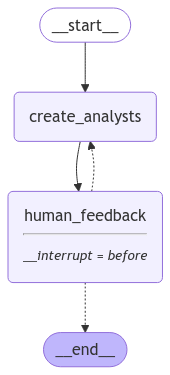

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Harper
Affiliation: Institute of Advanced Software
Role: Software Framework Specialist
Description: Dr. Emily Harper is focused on understanding how new frameworks, particularly LangGraph, can enhance software development practices. Her main interest lies in how LangGraph simplifies complex programming tasks, increasing efficiency, reducing costs, and minimizing errors. She is motivated by the potential of LangGraph to streamline the development process and help teams deliver better software products faster.
--------------------------------------------------
Name: Rahul Mehta
Affiliation: Tech Trends Think Tank
Role: Technology Adoption Analyst
Description: Rahul Mehta analyzes market trends and the adoption of new technologies like LangGraph. He is particularly concerned with how quickly businesses are adopting LangGraph for their projects and what factors influence their decision-making process. His focus is on identifying barriers to adoption and strategies that can 

In [7]:
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff1c3e-f17c-6bfe-8002-bc19ac57723f'}}

In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Harper
Affiliation: Institute of Advanced Software
Role: Software Framework Specialist
Description: Dr. Emily Harper is focused on understanding how new frameworks, particularly LangGraph, can enhance software development practices. Her main interest lies in how LangGraph simplifies complex programming tasks, increasing efficiency, reducing costs, and minimizing errors. She is motivated by the potential of LangGraph to streamline the development process and help teams deliver better software products faster.
--------------------------------------------------
Name: Rahul Mehta
Affiliation: Tech Trends Think Tank
Role: Technology Adoption Analyst
Description: Rahul Mehta analyzes market trends and the adoption of new technologies like LangGraph. He is particularly concerned with how quickly businesses are adopting LangGraph for their projects and what factors influence their decision-making process. His focus is on identifying barriers to adoption and strategies that can 

In [9]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff1c3f-4104-6555-8004-cbab97d44714'}}

In [10]:
graph.get_state(thread).next

()

In [11]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [13]:
final_state.next


()

In [14]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)


Name: Elena Morris
Affiliation: Tech Innovators Startup
Role: Startup Entrepreneur
Description: Elena is the co-founder and CTO of Tech Innovators Startup, a small company focused on leveraging cutting-edge technologies to create scalable solutions. Her interest in LangGraph stems from the framework's potential to streamline the development of intelligent agents, reducing time-to-market and resource expenditure. As an entrepreneur, she is constantly looking for technologies that provide a competitive edge and LangGraph's ability to integrate efficiently with existing systems is particularly appealing to her startup's agile philosophy.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: AI and Machine Learning Research Institute
Role: AI Researcher
Description: Dr. Patel is a leading researcher in the field of artificial intelligence and machine learning, with a specific focus on agent-based models. His current research involves exploring how agent framew

In [15]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [18]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import ArxivLoader

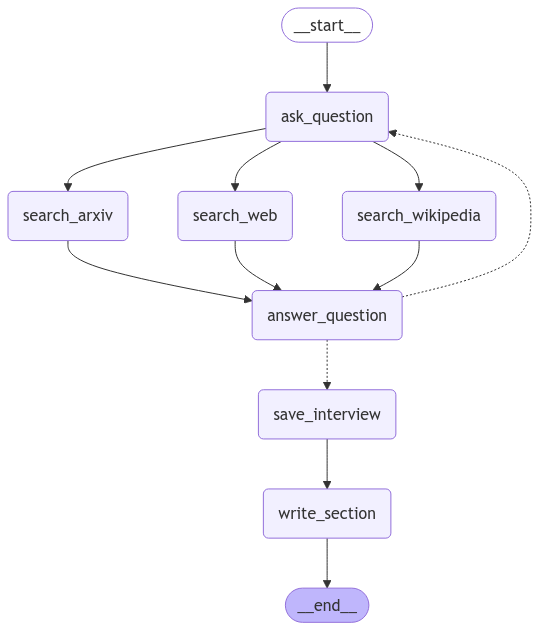

In [38]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}



def search_arxiv(state: InterviewState):
    """ Retrieve docs from arXiv """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])

    # Search
    search_docs = ArxivLoader(
        query=search_query.search_query,doc_content_chars_max = 1000,
        load_max_docs=1
    ).load()

    # Format - Handle metadata variations
    formatted_search_docs = []
    for doc in search_docs:
        # Extract arXiv ID from content if missing in metadata
        first_line = doc.page_content.split('\n')[0]
        arxiv_id = doc.metadata.get("entry_id",
                        first_line.split()[0].split(':')[-1].split('v')[0])  # Get base ID

        # Safely get title and authors with fallbacks
        title = doc.metadata.get("Title", "Untitled Paper")
        authors = ", ".join(doc.metadata.get("Authors", ["Unknown Author"]))

        formatted_doc = (
            f'<Document source="https://arxiv.org/abs/{arxiv_id}" '
            f'title="{title}" authors="{authors}"/>\n'
            f'{doc.page_content}\n</Document>'
        )
        formatted_search_docs.append(formatted_doc)

    return {"context": ["\n\n---\n\n".join(formatted_search_docs)]}
def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}




answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [39]:
analysts[1]


Analyst(affiliation='FutureTech Innovations', name='Cynthia Cho', role='CEO', description='Cynthia is the CEO of a gen AI native startup. She emphasizes the strategic benefits of adopting LangGraph in driving innovation and scaling her business efficiently. Cynthia is also concerned with how LangGraph can give her company a competitive edge in the rapidly evolving AI landscape.')

In [40]:

from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Streamlining System Integration with LangGraph: Enhancing Process Efficiency and Robustness

### Summary

The integration of LangGraph into existing systems presents significant opportunities for enhancing process efficiency and system robustness. LangGraph, a graph-based workflow technology, offers a unique approach to problem-solving in multi-agent environments and large language models (LLMs) implementations. Noteworthy advantages are being realized through its ability to streamline processes, improve information transmission, and facilitate dynamic decision-making within complex systems. This report highlights the technical advantages and practical implementations of LangGraph that cater to John’s professional focus and interest.

LangGraph's architecture improves the efficiency of information transmission across interconnected components, crucial for systems requiring quick and reliable data exchange [1]. In conjunction with CrewAI, LangGraph enables enhanced team collaboration by leveraging intelligent task allocation, optimizing the performance of systems handling complex tasks that a single agent cannot effectively tackle alone [1].

One of the novel aspects of LangGraph is its modular framework that contributes to the automation and effectiveness of machine translation (MT). This framework streamlines translation tasks through its specialized agents—TranslateEnAgent, TranslateFrenchAgent, and TranslateJpAgent—which provide accurate translations by using the semantic capabilities of LLMs, such as GPT-4o [2]. This modularity not only simplifies MT processes but also offers a scalable solution adaptable to various languages and contexts.

LangGraph also excels in real-time data analysis systems, particularly in big data environments. By integrating with Spark Streaming, it provides dynamic decision-making and tool invocation capabilities that overcome the limitations of static workflows. This integration allows for flexible control flows and efficient process management while reducing the need for constant human intervention, thereby improving overall system responsiveness and adaptability [3].

Additionally, within the domain of visualized and enhanced machine learning workflows, LangGraph's incorporation with Spark facilitates the automation of critical processes such as data preprocessing, feature engineering, and model evaluation. By utilizing Spark’s distributed computing capabilities, LangGraph enables scalable workflow orchestration and interactive data analysis, leading to improved workflow efficiency [4].

In summary, LangGraph’s graph-based technology, when integrated into current systems, not only streamlines operational efficiency and enhances robustness but also provides a versatile framework powered by advanced AI capabilities. This makes it an ideal solution for modern system challenges, aligning well with John’s focus on incorporating technical advancements to streamline processes.

### Sources
[1] https://arxiv.org/abs/Exploration  
[2] https://arxiv.org/abs/Agent  
[3] https://arxiv.org/abs/Research  
[4] https://arxiv.org/abs/Intelligent  

In [41]:

import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

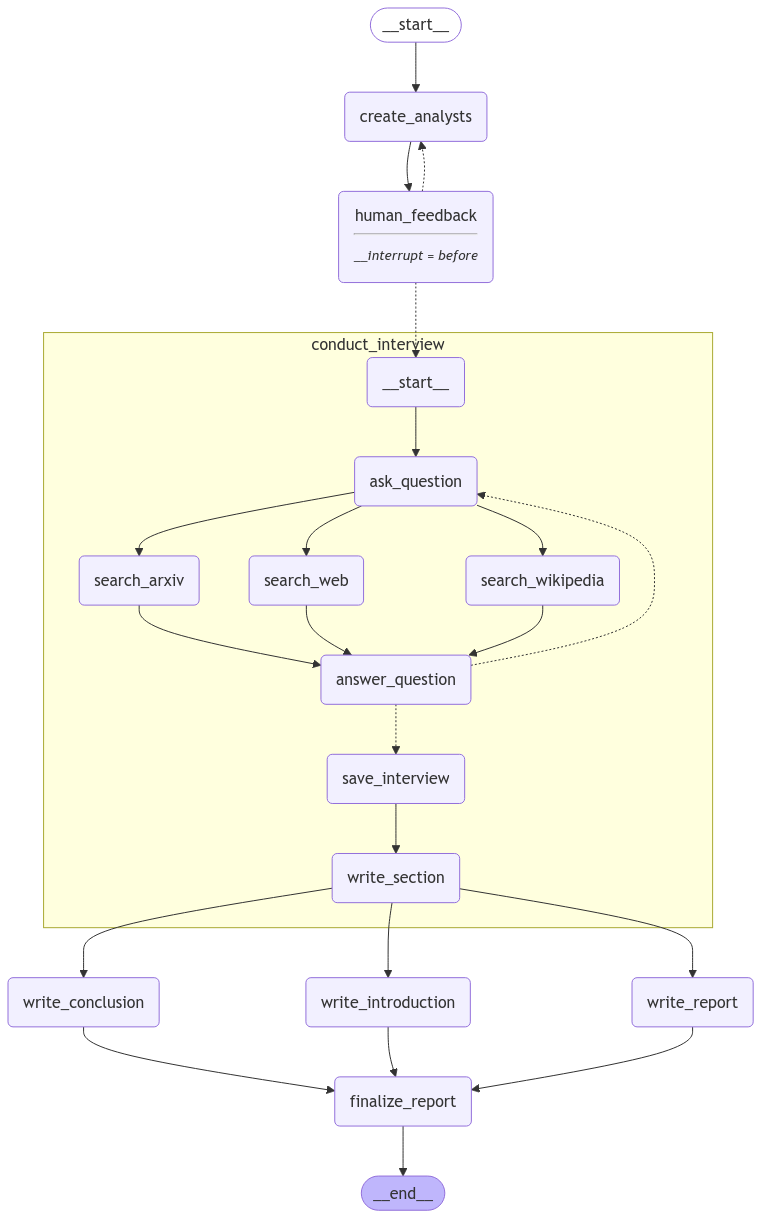

In [42]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [43]:
# Inputs
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovation Hub
Role: AI Framework Specialist
Description: Dr. Carter focuses on examining cutting-edge technologies in agent frameworks. She is particularly interested in how LangGraph can enhance AI model performance through its efficient handling of complex data structures and language models.
--------------------------------------------------
Name: André Fujimoto
Affiliation: Green Tech Innovations
Role: Sustainability Analyst
Description: André analyzes the environmental impact of technology frameworks. He is investigating how adopting LangGraph can reduce computational demand and energy consumption, promoting more sustainable AI practices.
--------------------------------------------------
Name: Clara Ngozi
Affiliation: Enterprise Solutions Inc.
Role: Business Integration Consultant
Description: Clara specializes in integrating new technologies into business operations. She explores how LangGraph can improve scalability and flexibility in e

In [44]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff1c5a-067e-697f-8002-50117efc301f'}}

In [45]:
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovation Hub
Role: AI Framework Specialist
Description: Dr. Carter focuses on examining cutting-edge technologies in agent frameworks. She is particularly interested in how LangGraph can enhance AI model performance through its efficient handling of complex data structures and language models.
--------------------------------------------------
Name: André Fujimoto
Affiliation: Green Tech Innovations
Role: Sustainability Analyst
Description: André analyzes the environmental impact of technology frameworks. He is investigating how adopting LangGraph can reduce computational demand and energy consumption, promoting more sustainable AI practices.
--------------------------------------------------
Name: Clara Ngozi
Affiliation: Enterprise Solutions Inc.
Role: Business Integration Consultant
Description: Clara specializes in integrating new technologies into business operations. She explores how LangGraph can improve scalability and flexibility in e

In [46]:
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff1c5a-2fab-658e-8004-91a76021d8f3'}}

In [48]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [49]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Harnessing LangGraph: Transforming High-Demand Applications

## Introduction

In the dynamic realm of technological advancement, LangGraph emerges as a pivotal agent framework reshaping high-demand applications. This report delves into LangGraph's revolutionary architecture, highlighting its impact on diverse domains such as machine translation, real-time data analysis, and machine learning. By employing a modular, graph-based orchestration, LangGraph enhances scalability and optimizes agent communication. It seamlessly integrates large language models like GPT-4o and empowers intelligent decision-making in complex workflows. From facilitating seamless business technology integration to accelerating AI product development, LangGraph offers a cutting-edge solution that enables businesses and developers to thrive in an increasingly competitive landscape.

---



LangGraph has emerged as a transformative agent framework that offers significant advantages for high-demand applications, integration into business technology, and rapid AI product development. Its unique contribution stems from its graph-based orchestration and modular architecture, optimizing agent communication and enhancing scalability.

Central to LangGraph’s advancements is its impact on workflow processes in machine translation, real-time data analysis, and machine learning. LangGraph distinguishes itself through modularity and graph-based orchestration, exemplifying superior solutions over traditional approaches. Notably, in machine translation, modules like TranslateEnAgent, TranslateFrenchAgent, and TranslateJpAgent leverage large language models (LLMs) such as GPT-4o to deliver contextually accurate translations, overcoming challenges found in conventional systems [1][2]. This specificity bolsters the automation of language tasks and reaffirms LangGraph’s capacity to facilitate precise global communication.

For real-time data analysis, LangGraph’s graph-based workflow construction addresses inefficiencies found in static workflows and stateful computations of traditional big data environments. Its dynamic and adaptable framework accommodates contemporary data-driven applications, thus offering businesses unprecedented operational flexibility and efficiency [2][3].

In machine learning, LangGraph’s integration with Spark fosters workflow scalability and visualizations crucial for modern tasks. Through automating essential processes like data preprocessing, feature engineering, and model evaluation, LangGraph addresses the demands of handling extensive data volumes and complex workflows [2]. This capability is complemented by integrating with systems like Agent AI and CrewAI, where coordinated agent actions lead to improved team performance and system reliability [3].

The business case for LangGraph further cements its value in enhancing technology integration within enterprises. By embedding advanced LLMs, LangGraph facilitates intelligent task management and bolsters business technology ecosystems with efficient resource allocation and task handling. This empowers organizations to adapt rapidly to market shifts and maintain a competitive edge [2][4].

LangGraph is likewise pivotal in the arena of rapid AI product development. As startups aim for innovation with the shortest possible time-to-market, LangGraph's capacity to orchestrate complex processes and its inherent adaptability make it essential for AI innovation [1]. Startup CEOs, like Elena, recognize LangGraph's potential to streamline AI-powered product deployments, offering significant strategic advantages in dynamic markets [3].

In summary, LangGraph stands out for its optimization of agent frameworks, facilitating high-performance communications, decision-making, and robust operational capabilities. Its role in machine translation, data analytics, and machine learning, coupled with strategic business integration and product development capacities, underscores its importance in the current and future tech landscapes.


---

## Conclusion

LangGraph has emerged as a vital player in advancing technical architectures for high-demand applications and revolutionizing business technology integration. By optimizing agent-based frameworks through modularity and graph-based orchestration, LangGraph enhances workflows in machine translation, real-time data analysis, and machine learning. Its seamless integration with large language models and platforms like Spark fosters enhanced scalability, automation, and decision-making. Businesses not only gain operational efficiency but also the ability to adapt rapidly to market demands. For AI startups and established enterprises alike, LangGraph offers a compelling solution to leverage cutting-edge technologies for competitive advantage and rapid AI product development.

## Sources
[1] https://arxiv.org/abs/Agent  
[2] https://arxiv.org/abs/Research  
[3] https://arxiv.org/abs/Intelligent  
[4] https://www.linkedin.com/pulse/langgraph-challenges-opportunities-multi-agent-riyaz-jaleel-ja3wc  
[5] https://www.getzep.com/ai-agents/langchain-agents-langgraph  
[6] https://arxiv.org/abs/Exploratio